In [1]:
!python -m ipykernel install --user --name=myenv

Installed kernelspec myenv in C:\Users\Administrator\AppData\Roaming\jupyter\kernels\myenv


c:\Users\Administrator\Desktop\EURUSD\env\Lib\site-packages\ta\trend.py:1030: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  self._psar[i] = high2
C:\Users\Administrator\AppData\Local\Temp\1\ipykernel_9084\1055547609.py:37: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:257.)
  self.features = torch.tensor(self.features, dtype=torch.float32)


📌 Training Started...
Epoch  1/30, Loss: 0.003501, Accuracy: 99.31%
Epoch  2/30, Loss: 0.000040, Accuracy: 99.82%
Epoch  3/30, Loss: 0.000029, Accuracy: 99.85%
Epoch  4/30, Loss: 0.000037, Accuracy: 99.83%
Epoch  5/30, Loss: 0.000033, Accuracy: 99.84%
Epoch  6/30, Loss: 0.000030, Accuracy: 99.84%
Epoch  7/30, Loss: 0.000034, Accuracy: 99.84%
Epoch  8/30, Loss: 0.000036, Accuracy: 99.83%
Epoch  9/30, Loss: 0.000037, Accuracy: 99.83%
Epoch 10/30, Loss: 0.000030, Accuracy: 99.85%
Epoch 11/30, Loss: 0.000035, Accuracy: 99.83%
Epoch 12/30, Loss: 0.000028, Accuracy: 99.85%
Epoch 13/30, Loss: 0.000027, Accuracy: 99.86%
Epoch 14/30, Loss: 0.000029, Accuracy: 99.85%
Epoch 15/30, Loss: 0.000032, Accuracy: 99.84%
Epoch 16/30, Loss: 0.000024, Accuracy: 99.86%
Epoch 17/30, Loss: 0.000025, Accuracy: 99.86%
Epoch 18/30, Loss: 0.000026, Accuracy: 99.86%
Epoch 19/30, Loss: 0.000026, Accuracy: 99.86%
Epoch 20/30, Loss: 0.000026, Accuracy: 99.86%
Epoch 21/30, Loss: 0.000028, Accuracy: 99.85%
Epoch 22/30,

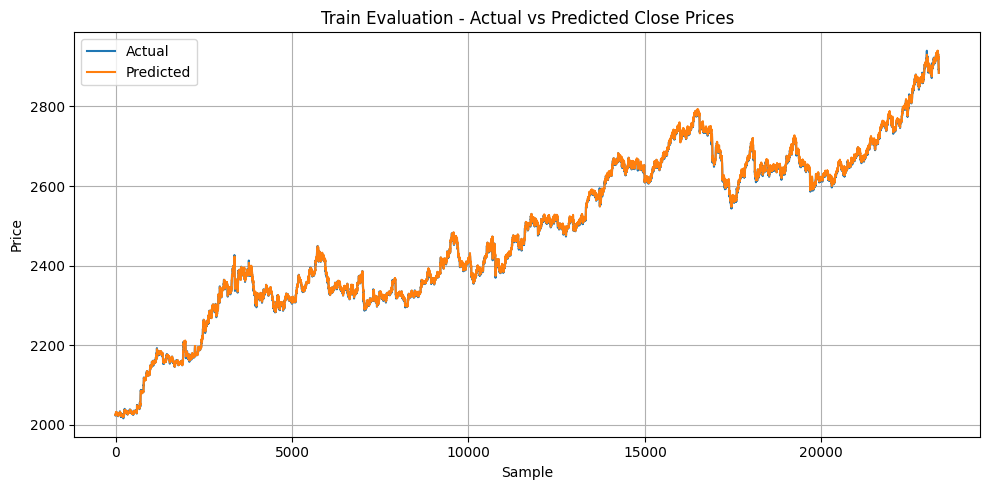


📊 Test Evaluation:
MAE: 11.2661, MSE: 241.8985, Accuracy: 99.64%


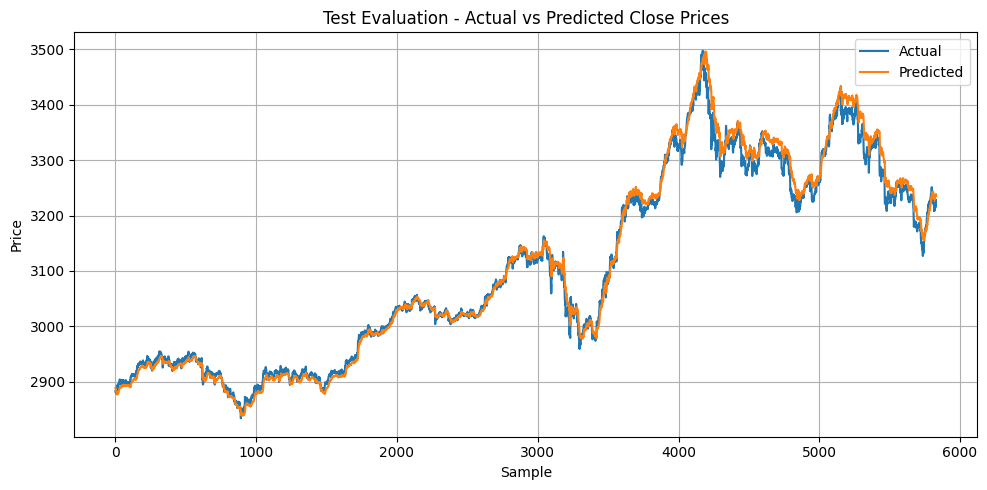


✅ Model saved to price_predictor.pth


In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset, DataLoader
from ta import add_all_ta_features
import matplotlib.pyplot as plt
from tqdm import tqdm

# ===== 1. خواندن داده و محاسبه اندیکاتورها =====
def load_data(filename):
    df = pd.read_csv(filename, sep='\t')
    df.columns = ['date', 'time', 'open', 'high', 'low', 'close', 'tick_volume', 'volume', 'spread']
    df['datetime'] = pd.to_datetime(df['date'] + ' ' + df['time'])
    df = df.sort_values('datetime')
    df.set_index('datetime', inplace=True)
    df = df[['open', 'high', 'low', 'close', 'tick_volume']]
    df = add_all_ta_features(df, open="open", high="high", low="low", close="close", volume="tick_volume", fillna=True)
    return df

# ===== 2. ساخت دیتاست =====
class PriceDataset(Dataset):
    def __init__(self, df, window=3):
        self.features = []
        self.labels = []
        feature_cols = [col for col in df.columns if col != 'close']
        scaler = MinMaxScaler()
        df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)
        self.scaler_y = MinMaxScaler()
        close_scaled = self.scaler_y.fit_transform(df[['close']])

        for i in range(window, len(df_scaled) - 1):
            self.features.append(df_scaled.iloc[i - window:i].values)
            self.labels.append(close_scaled[i + 1][0])

        self.features = torch.tensor(self.features, dtype=torch.float32)
        self.labels = torch.tensor(self.labels, dtype=torch.float32).unsqueeze(1)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

# ===== 3. مدل LSTM =====
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=2):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])

# ===== 4. آموزش =====
def train_model(model, dataloader, scaler_y, epochs=30, lr=1e-3):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        total_loss = 0
        percent_errors = []
        model.train()
        for x, y in dataloader:
            pred = model(x)
            loss = criterion(pred, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            y_true_inv = scaler_y.inverse_transform(y.detach().numpy())
            y_pred_inv = scaler_y.inverse_transform(pred.detach().numpy())
            percent_error = np.mean(np.abs((y_true_inv - y_pred_inv) / y_true_inv)) * 100
            percent_errors.append(percent_error)

        avg_loss = total_loss / len(dataloader)
        avg_percent_error = np.mean(percent_errors)
        accuracy = 100 - avg_percent_error
        print(f"Epoch {epoch + 1:2d}/{epochs}, Loss: {avg_loss:.6f}, Accuracy: {accuracy:.2f}%")

# ===== 5. ارزیابی =====
def evaluate_model(model, dataset, title="Evaluation"):
    model.eval()
    X, y = dataset[:]
    with torch.no_grad():
        preds = model(X).numpy()
        y_true = y.numpy()

    y_true_inv = dataset.scaler_y.inverse_transform(y_true)
    preds_inv = dataset.scaler_y.inverse_transform(preds)

    mse = np.mean((preds_inv - y_true_inv) ** 2)
    mae = np.mean(np.abs(preds_inv - y_true_inv))
    accuracy = 100 - (np.mean(np.abs((preds_inv - y_true_inv) / y_true_inv)) * 100)

    print(f"\n📊 {title}:")
    print(f"MAE: {mae:.4f}, MSE: {mse:.4f}, Accuracy: {accuracy:.2f}%")

    # نمودار
    plt.figure(figsize=(10, 5))
    plt.plot(y_true_inv, label='Actual', linewidth=1.5)
    plt.plot(preds_inv, label='Predicted', linewidth=1.5)
    plt.title(f"{title} - Actual vs Predicted Close Prices")
    plt.xlabel("Sample")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# ===== 6. اجرای اصلی =====
if __name__ == "__main__":
    df = load_data("XAUUSD-VIP_M15.txt")

    # تقسیم‌بندی داده
    split_ratio = 0.8
    split_index = int(len(df) * split_ratio)
    df_train = df.iloc[:split_index]
    df_test = df.iloc[split_index:]

    train_dataset = PriceDataset(df_train)
    test_dataset = PriceDataset(df_test)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

    input_size = train_dataset.features.shape[2]
    model = LSTMModel(input_size=input_size)

    print("📌 Training Started...")
    train_model(model, train_loader, train_dataset.scaler_y)

    evaluate_model(model, train_dataset, "Train Evaluation")
    evaluate_model(model, test_dataset, "Test Evaluation")

    # ذخیره مدل
    torch.save(model.state_dict(), "price_predictor.pth")
    print("\n✅ Model saved to price_predictor.pth")
